In [1]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from keras.preprocessing.image import load_img
from tensorflow.python.client import device_lib 
from google.colab import files
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img
import imgaug as ia
from imgaug import augmenters as iaa
from PIL import Image
import os
import glob
import time
from IPython import display

In [ ]:
tf.__version__

'2.5.0'

In [ ]:
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12147676763029057091
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15395979264
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9442530706607096333
physical_device_desc: "device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:00:04.0, compute capability: 7.0"
]


# Initial data

Here we implement the DCGAN approach to generating portraits based on a dataset of paintings by various artists.

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
data = []
for filename in os.listdir("/content/gdrive/MyDrive/portraits"):
    if filename.endswith("jpg"): 
        data.append(filename)

In [ ]:
portraits_raw = []
for file in data:
  opened = glob.glob("/content/gdrive/MyDrive/portraits/"+file)
  image = load_img(opened[0])
  img_array = img_to_array(image)
  portraits_raw.append(img_array)

We look at an arbitrary portrait, and see that is is Frida.

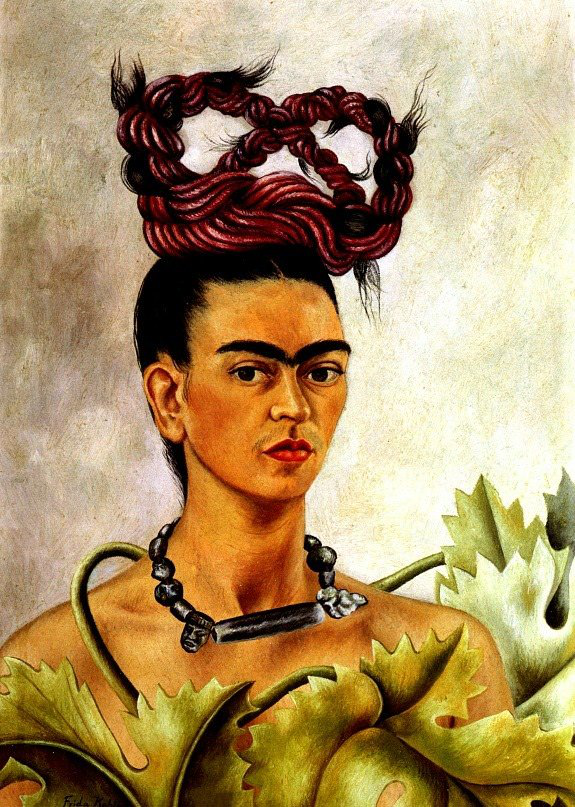

In [ ]:
array_to_img(portraits_raw[456])

In [ ]:
len(portraits_raw)

1082

We will try to train our initial GAN on these 1000 paintings, so this is very likely to not be enough. We will likely encounter overfitting.

As the portraits are of varying sizes, we need a uniform size. We have decided on 160 by 160, as anything larger tends to not perform well in GANs. However, we can't simply resize them, as this will warp the paintings. Instead, we use tensorflow's "smart resize", which focuses on what it deems is the most important. This process is not perfect, so we have to manually check if any portraits have their head cut off.

In [ ]:
resized = []
for i in portraits_raw:
  resized.append(tf.keras.preprocessing.image.smart_resize(i,(160,160)))

Here we see the smart resize at work for the same portrait as above.

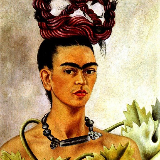

In [ ]:
array_to_img(resized[456])

In [ ]:
# to clear the RAM
portraits_raw = []

In [ ]:
for i in range(len(resized)):
  pic = array_to_img(resized[i])
  pic.save('/content/gdrive/MyDrive/resized_portraits' + "/" + data[i])

# Augmentation for further training



Here we augment the dataset. As the subsequent GAN has overfitted the initial dataset, we randomly flip some portraits left to right, and change the hue and saturation using the imgaug library.

In [ ]:
seq = iaa.Sequential([
    iaa.Fliplr(0.5),
    iaa.AddToHueAndSaturation((-20, 20))
])

In [ ]:
path, dirs, files = next(os.walk('/content/gdrive/MyDrive/resized_portraits'))
for file in sorted(files):
  image = Image.open(path + "/" + file)
  if image.mode == "RGB":    
      image.save('/content/gdrive/MyDrive/transforms' + "/" + file)
      image_np = np.array(image)
      images = [image_np] * 5
      images_aug = seq(images=images)
      for i in range(0, 5):
        im = Image.fromarray(np.uint8(images_aug[i]))
        to_file = '/content/gdrive/MyDrive/transforms' + "/" + file[:-4] + '_' + str(i).zfill(2) + '.jpg'
        im.save(to_file)


In [ ]:
data = []
for filename in os.listdir("/content/gdrive/MyDrive/transforms"):
    if filename.endswith("jpg"): 
        data.append(filename)

In [ ]:
portraits = []
for file in data:
  opened = glob.glob("/content/gdrive/MyDrive/transforms/"+file)
  image = load_img(opened[0])
  img_array = img_to_array(image)
  portraits.append(img_array)

As that last cell takes around 50 minutes to run on colab, we save the resulting numpy array so we don't have to deal with that again.

In [ ]:
# clear RAM
portraits_raw = []

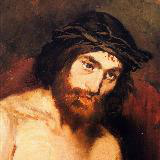

In [ ]:
array_to_img(portraits[4000])

In [ ]:
len(portraits)

6220

We have roughly 6000 portraits now.,

In [ ]:
transfer = np.array(portraits)

Save array for faster retrieval on runtime reset.

In [ ]:
np.save('/content/gdrive/MyDrive/GANs/portraits.npy',transfer)

In [4]:
transfer = np.load('/content/gdrive/MyDrive/GANs/portraits.npy')

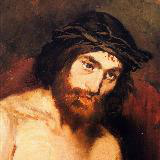

In [5]:
array_to_img(transfer[4000])

Success.

# GAN setup and training

First, we normalize to -1,1

In [6]:
train_images = (transfer-127.5)/127.5

Then we set the buffer and batch sizes, and initialize the training dataset.

In [7]:
BUFFER_SIZE = 10000
BATCH_SIZE = 256

In [8]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

Now we build the models. We start with the Generator, taking an input shape of 100, and progressively growing the dimensions from 10,10 to 160,160 using Conv2DTranspose.

In [ ]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(10*10*512, use_bias=False, input_shape=(100,)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Reshape((10, 10, 512)))
    assert model.output_shape == (None, 10, 10, 512)  

    model.add(tf.keras.layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 20, 20, 256)
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 40, 40, 128)
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 80, 80, 64)
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 160, 160, 3)

    return model

Generator currently should generate random noise. Let's check if the colour scheme is captured properly.

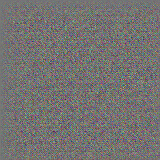

In [ ]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

array_to_img(generated_image[0,:,:,:]* 127.5 + 127.5)

Yes, completely random-coloured pixels.

Next, we build the discriminator architecture. Very similar to the generator, but in reverse. We add dropout as well.

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[160, 160, 3]))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.2))

    model.add(tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.2))

    model.add(tf.keras.layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.2))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1))

    return model

The discriminator is untrained, and should output a value close to zero. Once training begins, negative values indicate fakes, positives indicate real portraits.

In [ ]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00032456]], shape=(1, 1), dtype=float32)


Next we define the loss functions.

In [9]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [10]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [11]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

We use Adam as an optimizer, with a smaller learning rate. Otherwise training is extremely unstable.

In [12]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

We set a seed, so that the training image display uses the same seed for aesthetic purposes in case we want to watch.

In [68]:
noise_dim = 100
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])

We define a training step.

In [14]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

We define the training function, inserting a nice checkpoint to save our training in case something gets interrupted.

In [15]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)
    
    # this will save a checkpoint every 100 epochs in case anything is interrupted
    if (epoch + 1) % 100 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)
    
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

And we build a function to convert the arrays to images and display them.

In [16]:
def generate_and_save_images(model, epoch, test_input):
  
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(10, 10))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      Z = array_to_img(predictions[i,:,:,:]* 127.5 + 127.5)
      plt.imshow(Z)
      plt.axis('off')

  plt.show()

Below we have a list of all the models we have saved.

In [17]:
!ls /content/gdrive/MyDrive/GANs/saved_model/

GAN_DISCRIMINATOR_augmented_epoch39100	GAN_GENERATOR_augmented_epoch39100
GAN_DISCRIMINATOR_augmented_epoch39200	GAN_GENERATOR_augmented_epoch39200
GAN_DISCRIMINATOR_augmented_epoch39700	GAN_GENERATOR_augmented_epoch39700
GAN_DISCRIMINATOR_augmented_epoch39800	GAN_GENERATOR_augmented_epoch39800
GAN_DISCRIMINATOR_augmented_epoch40000	GAN_GENERATOR_augmented_epoch40000
GAN_DISCRIMINATOR_augmented_epoch40200	GAN_GENERATOR_augmented_epoch40200
GAN_DISCRIMINATOR_augmented_epoch40400	GAN_GENERATOR_augmented_epoch40400
GAN_DISCRIMINATOR_augmented_epoch43400	GAN_GENERATOR_augmented_epoch43400
GAN_DISCRIMINATOR_augmented_epoch43600	GAN_GENERATOR_augmented_epoch43600
GAN_DISCRIMINATOR_augmented_epoch43800	GAN_GENERATOR_augmented_epoch43800
GAN_DISCRIMINATOR_augmented_epoch44000	GAN_GENERATOR_augmented_epoch44000
GAN_DISCRIMINATOR_augmented_epoch44200	GAN_GENERATOR_augmented_epoch44200
GAN_DISCRIMINATOR_augmented_epoch44400	GAN_GENERATOR_augmented_epoch44400
GAN_DISCRIMINATOR_augmented_epoch44600

Here we can load a previously-saved model, as colab pro only allows a 24 hour connection period.

In [67]:
generator = tf.keras.models.load_model('/content/gdrive/MyDrive/GANs/saved_model/GAN_GENERATOR_epoch55000')
discriminator = tf.keras.models.load_model('/content/gdrive/MyDrive/GANs/saved_model/GAN_DISCRIMINATOR_epoch55000')

And finally, we set the checkpoint directory.

In [19]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

We train the model using the below, specifying the number of epochs.

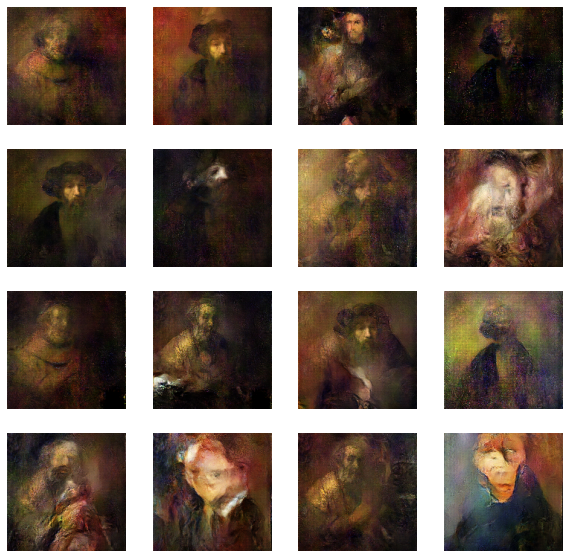

In [69]:
train(train_dataset, 1)

Our GAN has clearly overfitted to some characteristic Rembrandts. The GAN really loves "A Bearded Man in a Cap", "Homer Dictating his Verses", and "A Franciscan Friar". Sometimes there are frightening combinations of all three.

We can restore a checkpoint if training is interrupted:

In [ ]:
#checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

And we can save models periodically.

In [ ]:
generator.save('/content/gdrive/MyDrive/GANs/saved_model/GAN_GENERATOR_augmented_epoch54800')
discriminator.save('/content/gdrive/MyDrive/GANs/saved_model/GAN_DISCRIMINATOR_augmented_epoch54800')

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/GANs/saved_model/GAN_GENERATOR_augmented_epoch54800/assets
INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/GANs/saved_model/GAN_DISCRIMINATOR_augmented_epoch54800/assets


# Generate images

We insert random noise into the loaded generator, and have it generate an image.

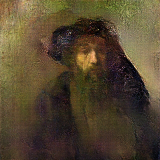

In [287]:
noise = tf.random.normal([1, 100])
generated_image2 = generator(noise, training=False)

array_to_img(generated_image2[0,:,:,:]* 127.5 + 127.5)

We have the loaded discriminator make its decision.

In [288]:
decision = discriminator(generated_image2)
print (decision)

tf.Tensor([[-3.243355]], shape=(1, 1), dtype=float32)


And we save any images that we like!

In [190]:
pic = array_to_img(generated_image2[0,:,:,:]* 127.5 + 127.5)

In [191]:
pic.save('/content/gdrive/MyDrive/GANs/generated_pics_55000/21.jpg')